In [2]:
import os

In [3]:
from tqdm import tqdm

In [4]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

In [5]:
from ase import io
from ase.visualize import view
from ase.build import sort, molecule
from ase.optimize import QuasiNewton, FIRE

In [6]:
from helpers import validate
from helpers import read_log
from helpers import read_metrics

In [7]:
from pyace import PyACECalculator

In [8]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['font.size'] = 18
# mpl.rcParams['font.family'] = 'Times'

mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.minor.width'] = 1.5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['xtick.minor.size'] = 3.
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.top']=True

mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.minor.width'] = 1.5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['ytick.minor.size'] = 3.
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.right']=True

In [9]:
calc = PyACECalculator('../../upfit/10000_ladder/asi/interim_potential_ladder_step_1.yaml',
    keep_extrapolative_structures=True,
    gamma_lower_bound=1.2,
    gamma_upper_bound=10,
    stop_at_large_extrapolation=False)
calc.set_active_set('../../upfit/10000_ladder/asi/interim_potential_ladder_step_1.asi')

In [10]:
def linear_fn(x, a, b):
    return a*x + b

In [11]:
import os
import warnings
def read_log(path):
    os.system(f'cat {path}/lmp.out | grep -e Step -e Loop -n > read_log')
    file = open('read_log').readlines()
    os.system('rm read_log')
    log_lst = list()
    for i in range(0,len(file),2):
        try:
                n1 = int(file[i].replace(':',' ').split()[0])
                n2 = int(file[i+1].replace(':',' ').split()[0])
                log_lst.append(pd.read_csv(f'{path}/lmp.out',
                                   skiprows=n1-1, nrows=n2-n1-1, sep= '\s+'))
        except:
            break

    if(len(file)%2 ==0):
        return log_lst
    else:
        warnings.warn('Last run is not finished')            
        n = int(file[-1].replace(':',' ').split()[0])
        log_lst.append(pd.read_csv(f'{path}/lmp.out', skiprows=n-1, sep= '\s+'))

    return log_lst

In [32]:
def write_lmp_file(P, T, path, pot_dir, barostat='iso', n_steps_eq = 2*10**3, n_steps_pr = 2*10**7):
    s= np.random.randint(99999)
    lines= ['\n',
 'units\t\tmetal\t\t\t\t\t\t## E in [eV], t in [ps], P in [10000 Pa], l in [A]\n',
 'atom_style\tatomic\t\t\t\t\t\t## mass x y z vx vy vz \n',
 '\n',
 'neighbor\t0.5 bin\t\t\t\t\t\t## neighbor list, skin = 0.5 Angstrom\n',
 'neigh_modify\tevery 2 delay 10 check yes\t\t\t## update of neighbor list\n',
 '\n',
 '############################## main variables\n',
f'variable        seed equal {s}\n',
 '\n',
f'variable\ttemperature equal {T}\n',
 'variable\ttempDamp equal 0.1\n',
 '\n',
f'variable        pressure equal {P}\n',
 'variable        pressureDamp equal 1.0 \t\t\t\t# This is 1 ps\n',
 '\n',
 '##############################\n',
 '\n',
 'read_data water.dat\n',
 '\n',
 'mass\t\t1 1.008    # H\n',
 'mass\t\t2 15.9994  # O\n',
 '\n',
 '\n',
 'pair_style\tpace/extrapolation\n',
 f'pair_coeff\t* * {pot_dir}/interim_potential_ladder_step_1.yaml\
 {pot_dir}/interim_potential_ladder_step_1.asi H O\n',
 '\n',
 'fix pace_gamma all pair 1000 pace/extrapolation gamma 1\n',
 'compute max_pace_gamma all reduce max f_pace_gamma\n',
 'variable dump_skip equal "c_max_pace_gamma < 10"\n',
 '\n',
 'dump pace_dump all custom 1000 extrapolative_structures.dump id type x y z f_pace_gamma\n',
 'dump_modify pace_dump skip v_dump_skip\n',
 'dump_modify pace_dump element H O\n',
 '\n',
 'variable max_pace_gamma equal c_max_pace_gamma',
 '\n',
 '\n',
 'timestep\t0.0005\t\t\t\t\t\t## timestep = 0.0005*ps = 0.5 fs\n',
 '\n',
 'thermo\t\t100\n',
 'thermo_style custom step etotal pe ke press temp vol enthalpy density c_max_pace_gamma\n',
 '\n',
 '\n',
 'min_style cg\n',
 'minimize 0.0 5.0e-4 10000 100000\n'
 '\n',
 '################## equilibration of main calculation\n',
 '# Equilibrate to specified number of ice\n',
 '\n',
f'fix             3 all nph {barostat} '+' ${pressure} ${pressure} ${pressureDamp}\n',
 'fix             4 all temp/csvr ${temperature} ${temperature} ${tempDamp} ${seed}\n',
 'velocity \tall create ${temperature} ${seed} dist gaussian\n',
 '\n',
f'run {n_steps_eq} \n',
 '\n',
 'unfix 3\n',
 'unfix 4\n',
 '\n',
 '################## main calculation\n',
 '\n',
 '#dump \t\t3 all custom 1000 traj.lammpstrj id type element x y z\n',
 '#dump_modify     3 element H O\n',
 '\n',
 '\n',
f'fix             3 all nph {barostat} '+'${pressure} ${pressure} ${pressureDamp}\n',
 'fix             4 all temp/csvr ${temperature} ${temperature} ${tempDamp} ${seed}\n',
 'velocity \tall create ${temperature} ${seed} dist gaussian\n',
 '\n',
f'run             {n_steps_pr}\n',
 '\n',
 'unfix\t\t3\n',
 'unfix\t\t4\n',
 'write_data data.data']
    fr = open(f'{path}/in.lammps', 'w')
    fr.writelines(lines)
    fr.close()
    return

In [24]:
atoms_ice = io.read('../vii/30000_bar/1-bulk/450/traj.lammpstrj', index=':')

In [26]:
view(atoms_ice, viewer='nglview')

In [14]:
atoms_liq = io.read('../vii/dist/liquid/dump.na', index=':')
for atoms in tqdm(atoms_liq):
    atoms.set_chemical_symbols(list(map(lambda s: 'O' if s == 'He' else s, atoms.get_chemical_symbols())))

100%|██████████| 400/400 [00:00<00:00, 4409.02it/s]


In [15]:
view(atoms_liq, viewer='nglview')

In [28]:
ph_1 = atoms_ice[-1]
ph_1.wrap()
view(ph_1, viewer='nglview')

In [29]:
ph_1.set_calculator(calc)
opt_ph_1 = QuasiNewton(ph_1)
opt_ph_1.run(fmax=1)

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 15:03:42    -6176.928188*       4.7116
BFGSLineSearch:    1[  2] 15:03:46    -6199.598384*       2.1300
BFGSLineSearch:    2[  4] 15:03:49    -6208.224742*       3.4353
BFGSLineSearch:    3[  6] 15:03:52    -6220.486110*       3.1778
BFGSLineSearch:    4[  8] 15:03:55    -6224.494949*       1.8871
BFGSLineSearch:    5[  9] 15:03:57    -6236.505488*       3.9368
BFGSLineSearch:    6[ 11] 15:04:00    -6240.398581*       2.1386
BFGSLineSearch:    7[ 13] 15:04:04    -6242.119187*       1.7823
BFGSLineSearch:    8[ 15] 15:04:07    -6246.438049*       5.8739
BFGSLineSearch:    9[ 17] 15:04:10    -6247.968454*       2.2803
BFGSLineSearch:   10[ 19] 15:04:13    -6249.325297*       3.7498
BFGSLineSearch:   11[ 21] 15:04:16    -6250.873187*       2.0118
BFGSLineSearch:   12[ 23] 15:04:19    -6251.329191*       2.3190
BFGSLineSearch:   13[ 24] 15:04:21    -62

True

In [30]:
ph_2 = atoms_liq[-1]
ph_2.wrap()
view(ph_2, viewer='nglview')

In [22]:
ph_2.set_calculator(calc)
opt_ph_2 = QuasiNewton(ph_2)
opt_ph_2.run(fmax=1)

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 16:33:52    -4103.794842*       4.0064
BFGSLineSearch:    1[  2] 16:33:53    -4115.806914*       1.9090
BFGSLineSearch:    2[  4] 16:33:55    -4121.065632*       3.4526
BFGSLineSearch:    3[  6] 16:33:57    -4127.116027*       3.9976
BFGSLineSearch:    4[  8] 16:33:59    -4129.185546*       1.7374
BFGSLineSearch:    5[ 10] 16:34:01    -4133.762434*       5.2114
BFGSLineSearch:    6[ 12] 16:34:03    -4136.450611*       3.2172
BFGSLineSearch:    7[ 14] 16:34:04    -4137.603262*       3.8082
BFGSLineSearch:    8[ 16] 16:34:06    -4138.491207*       3.3774
BFGSLineSearch:    9[ 18] 16:34:08    -4140.313829*       4.0610
BFGSLineSearch:   10[ 20] 16:34:10    -4141.484792*       2.1516
BFGSLineSearch:   11[ 22] 16:34:12    -4142.286731*       2.1206
BFGSLineSearch:   12[ 24] 16:34:14    -4143.429746*       0.9460


True

In [37]:
def run_md(P, T, ph_1, ph_2, path_ph1, path_ph2, barostat_ph1, barostat_ph2, 
           n_steps_eq_ph1, n_steps_pr_ph1, n_steps_eq_ph2, n_steps_pr_ph2, skip=0):
    try:
        os.mkdir(path_ph1+f'_T_{T}_P_{P}')
        os.chdir(path_ph1+f'_T_{T}_P_{P}')
        io.write('water.dat', ph_1, format='lammps-data', specorder=['H', 'O'])
        write_lmp_file(P, T, path_ph1+f'_T_{T}_P_{P}', pot_dir, barostat_ph1, n_steps_eq_ph1, n_steps_pr_ph1)
        os.system('export CUDA_VISIBLE_DEVICES=1;\
        nohup lmp_volta -k on g 1  -sf kk -pk kokkos newton on neigh half -in in.lammps > lmp.out')
        print(f'Simulations_ph1_T_{T}_P_{P} has been done')
    except:
        print(f'Simulations_ph1_T_{T}_P_{P} has been executed and will be used')
    
    try:
        os.mkdir(path_ph2+f'_T_{T}_P_{P}')
        os.chdir(path_ph2+f'_T_{T}_P_{P}')
        io.write('water.dat', ph_2, format='lammps-data', specorder=['H', 'O'])
        write_lmp_file(P, T, path_ph2+f'_T_{T}_P_{P}', pot_dir, barostat_ph2, n_steps_eq_ph2, n_steps_pr_ph2)
        os.system('export CUDA_VISIBLE_DEVICES=1;\
        nohup lmp_volta -k on g 1  -sf kk -pk kokkos newton on neigh half -in in.lammps > lmp.out')
        print(f'Simulations_ph2_T_{T}_P_{P} has been done')
    except:
        print(f'Simulations_ph2_T_{T}_P_{P} has been executed and will be used')
    
    n_mols_ph1 = int(len(ph_1)/3)
    n_mols_ph2 = int(len(ph_2)/3)
    
    log_ph1 = read_log(path_ph1+f'_T_{T}_P_{P}')[-1]
    log_ph2 = read_log(path_ph2+f'_T_{T}_P_{P}')[-1]

    h_ph1=np.mean(log_ph1.Enthalpy[skip:],axis=0)/n_mols_ph1
    vol_ph1=np.mean(log_ph1.Volume[skip:],axis=0)/n_mols_ph1

    h_ph2=np.mean(log_ph2.Enthalpy[skip:],axis=0)/n_mols_ph2
    vol_ph2=np.mean(log_ph2.Volume[skip:],axis=0)/n_mols_ph2
    
    
    c_bar_eV_Acube=6.241509e-7
    return 1/(T*(vol_ph1-vol_ph2)*c_bar_eV_Acube/(h_ph1-h_ph2))

In [38]:
pot_dir = '/home/users/saadie5f/piaggi/phase_diagram/upfit/10000_ladder/asi'

path_ph1 = '/home/users/saadie5f/piaggi/phase_diagram/full/cc_int/vii-liq-2nd/vii'
path_ph2 = '/home/users/saadie5f/piaggi/phase_diagram/full/cc_int/vii-liq-2nd/liq'


T = 462.948; P = 30000; T_step = -3
n_steps_eq_ph1 = 2*10**4; n_steps_pr_ph1 = 2*10**5
n_steps_eq_ph2 = 2*10**4; n_steps_pr_ph2 = 2*10**5
barostat_ph1 = 'aniso'; barostat_ph2 = 'iso'

skip = 100
n_pnts = 20

T_lst = list();
P_lst = list();
for i in range(n_pnts):
    T_lst.append(T); P_lst.append(P)
    
    k1 = run_md(P, T, ph_1, ph_2, path_ph1, path_ph2, barostat_ph1, barostat_ph2,
                    n_steps_eq_ph1, n_steps_pr_ph1, n_steps_eq_ph2, n_steps_pr_ph2, skip)

    k2 = run_md(P + 0.5 * T_step * k1, T + 0.5 * T_step, ph_1, ph_2, path_ph1, path_ph2,
                barostat_ph1, barostat_ph2,
                n_steps_eq_ph1, n_steps_pr_ph1, n_steps_eq_ph2, n_steps_pr_ph2, skip)

    k3 = run_md(P + 0.5 * T_step * k2, T + 0.5 * T_step, ph_1, ph_2, path_ph1, path_ph2, 
                barostat_ph1, barostat_ph2,
                n_steps_eq_ph1, n_steps_pr_ph1, n_steps_eq_ph2, n_steps_pr_ph2, skip)

    k4 = run_md(P + T_step * k3, T + T_step, ph_1, ph_2, path_ph1, path_ph2, 
                barostat_ph1, barostat_ph2,
                n_steps_eq_ph1, n_steps_pr_ph1, n_steps_eq_ph2, n_steps_pr_ph2, skip)

    P += (1./6.) * T_step * (k1 + 2*k2 + 2*k3 + k4)
    T += T_step

Simulations_ph1_T_462.948_P_30000 has been done
Simulations_ph2_T_462.948_P_30000 has been done
Simulations_ph1_T_461.448_P_29753.629604532947 has been done
Simulations_ph2_T_461.448_P_29753.629604532947 has been done
Simulations_ph1_T_461.448_P_29757.104203907482 has been done
Simulations_ph2_T_461.448_P_29757.104203907482 has been done
Simulations_ph1_T_459.948_P_29505.505669438877 has been done
Simulations_ph2_T_459.948_P_29505.505669438877 has been done
Simulations_ph1_T_459.948_P_29508.9397202987 has been done
Simulations_ph2_T_459.948_P_29508.9397202987 has been done
Simulations_ph1_T_458.448_P_29261.995079307984 has been done
Simulations_ph2_T_458.448_P_29261.995079307984 has been done
Simulations_ph1_T_458.448_P_29264.966026113703 has been done
Simulations_ph2_T_458.448_P_29264.966026113703 has been done
Simulations_ph1_T_456.948_P_29024.004021179993 has been done
Simulations_ph2_T_456.948_P_29024.004021179993 has been done
Simulations_ph1_T_456.948_P_29021.411304968115 has bee

Simulations_ph1_T_411.948_P_22138.992218447333 has been done
Simulations_ph2_T_411.948_P_22138.992218447333 has been done
Simulations_ph1_T_410.448_P_21918.826419202567 has been done
Simulations_ph2_T_410.448_P_21918.826419202567 has been done
Simulations_ph1_T_410.448_P_21923.792946134923 has been done
Simulations_ph2_T_410.448_P_21923.792946134923 has been done
Simulations_ph1_T_408.948_P_21710.88120606289 has been done
Simulations_ph2_T_408.948_P_21710.88120606289 has been done
Simulations_ph1_T_408.948_P_21709.857904275912 has been done
Simulations_ph2_T_408.948_P_21709.857904275912 has been done
Simulations_ph1_T_407.448_P_21497.00279324402 has been done
Simulations_ph2_T_407.448_P_21497.00279324402 has been done
Simulations_ph1_T_407.448_P_21492.062738430213 has been done
Simulations_ph2_T_407.448_P_21492.062738430213 has been done
Simulations_ph1_T_405.948_P_21270.91043612688 has been done
Simulations_ph2_T_405.948_P_21270.91043612688 has been done
Simulations_ph1_T_405.948_P_21

In [108]:
T_lst_1 = T_lst
P_lst_1 = P_lst

In [40]:
vii_liq = np.loadtxt('/home/users/saadie5f/piaggi/phase_diagram/full/cc_int/data/vii_liq.dat')

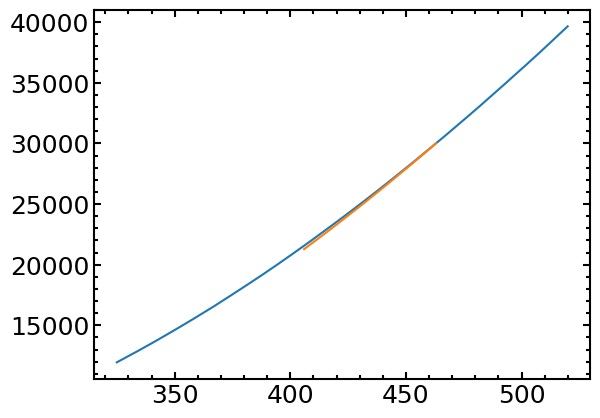

In [49]:
plt.plot(vii_liq[0,:],vii_liq[1,:]*1e4)
plt.plot(T_lst, P_lst)

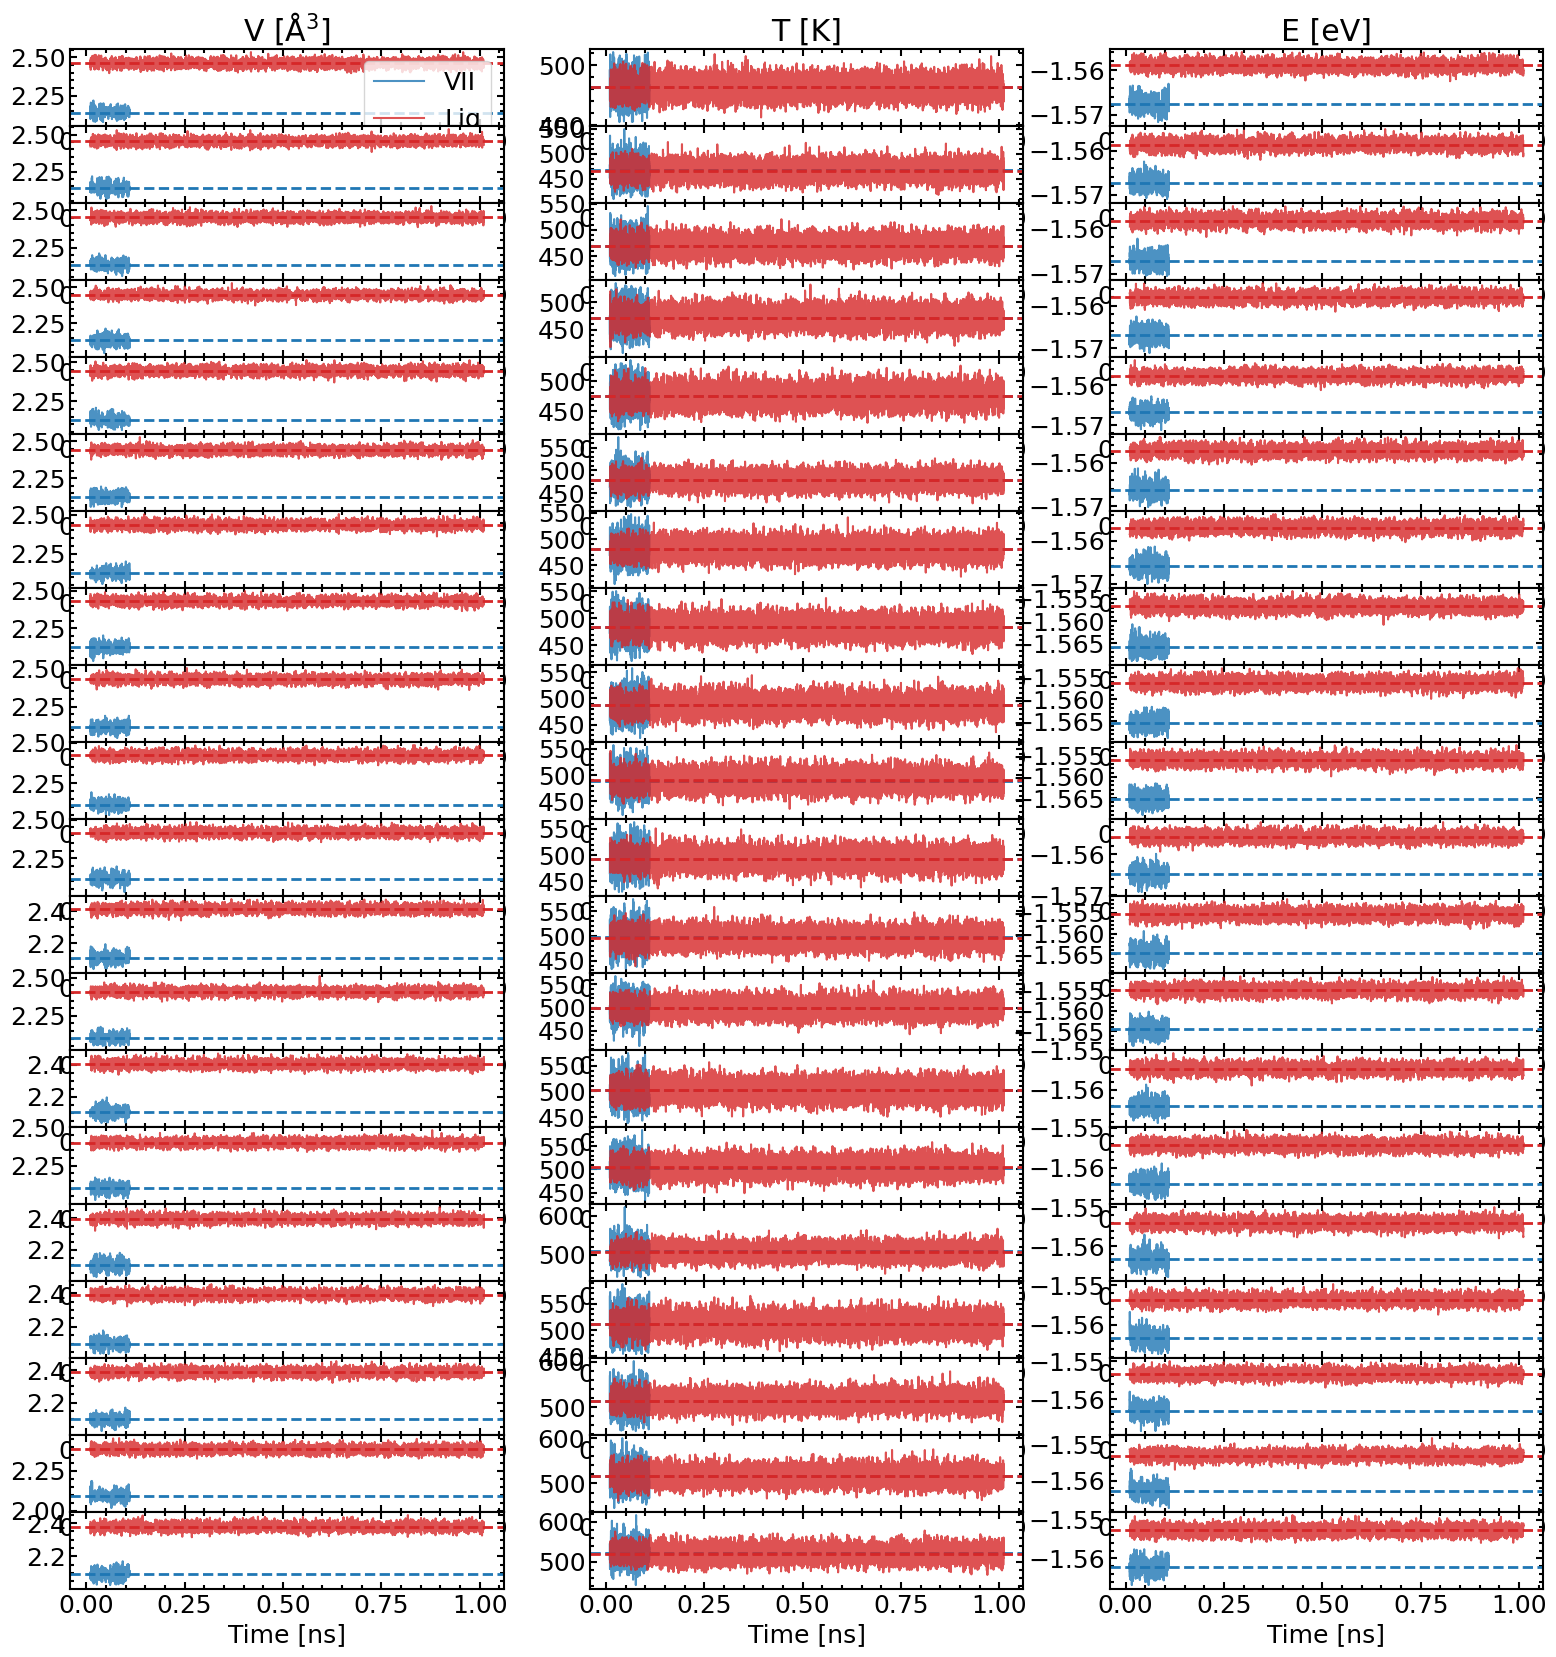

In [109]:
skip = 0
fig, ax = plt.subplots(figsize=(19,20), ncols=3, nrows=n_pnts)
fig.subplots_adjust(hspace=0)
alpha = 0.8
for i in range(n_pnts):
    path = f'/home/users/saadie5f/piaggi/phase_diagram/full/cc_int/vii-liq/vii_T_{T_lst[i]}_P_{P_lst[i]}'
    log = read_log(f'{path}')[-1]
        
    
    ax[i,0].plot(log.Step[skip:]*5e-7, log.Volume[skip:]/len(ph_1)/3, alpha=alpha, c='C0', label='VII')
    ax[i,0].axhline(log.Volume[skip:].mean()/len(ph_1)/3, ls='--', color='C0', lw=2)
    
    ax[i,1].plot(log.Step[skip:]*5e-7, log.Temp[skip:], alpha=alpha, c='C0')
    ax[i,1].axhline(log.Temp[skip:].mean(), ls='--', color='C0', lw=2)

    ax[i,2].plot(log.Step[skip:]*5e-7,log.TotEng[skip:]/len(ph_1)/3, alpha=alpha, c='C0')
    ax[i,2].axhline(log.TotEng[skip:].mean()/len(ph_1)/3, ls='--', color='C0', lw=2)
    
    path = f'/home/users/saadie5f/piaggi/phase_diagram/full/cc_int/vii-liq/liq_T_{T_lst[i]}_P_{P_lst[i]}'
    log = read_log(f'{path}')[-1]
        
    
    ax[i,0].plot(log.Step[skip:]*5e-7, log.Volume[skip:]/len(ph_2)/3, alpha=alpha, c='C3', label='Liq')
    ax[i,0].axhline(log.Volume[skip:].mean()/len(ph_2)/3, ls='--', color='C3', lw=2)
    
    ax[i,1].plot(log.Step[skip:]*5e-7, log.Temp[skip:], alpha=alpha, c='C3')
    ax[i,1].axhline(log.Temp[skip:].mean(), ls='--', color='C3', lw=2)

    ax[i,2].plot(log.Step[skip:]*5e-7,log.TotEng[skip:]/len(ph_2)/3, alpha=alpha, c='C3')
    ax[i,2].axhline(log.TotEng[skip:].mean()/len(ph_2)/3, ls='--', color='C3', lw=2)


ax[i,0].set_xlabel('Time [ns]')
ax[0,0].set_title('V [$\mathrm{\AA^{3}}$]')

ax[i,1].set_xlabel('Time [ns]')
ax[0,1].set_title('T [K]')

ax[i,2].set_xlabel('Time [ns]')
ax[0,2].set_title('E [eV]')
ax[0,0].legend()

In [116]:
pot_dir = '/home/users/saadie5f/piaggi/phase_diagram/upfit/10000_ladder/asi'

path_ph1 = '/home/users/saadie5f/piaggi/phase_diagram/full/cc_int/vii-liq/vii'
path_ph2 = '/home/users/saadie5f/piaggi/phase_diagram/full/cc_int/vii-liq/liq'


T = 462.948; P = 30000; T_step = -3
n_steps_eq_ph1 = 2*10**4; n_steps_pr_ph1 = 2*10**5
n_steps_eq_ph2 = 2*10**4; n_steps_pr_ph2 = 2*10**5
barostat_ph1 = 'aniso'; barostat_ph2 = 'iso'

skip = 100
n_pnts = 47

T_lst = list();
P_lst = list();
for i in range(n_pnts):
    T_lst.append(T); P_lst.append(P)
    
    k1 = run_md(P, T, ph_1, ph_2, path_ph1, path_ph2, barostat_ph1, barostat_ph2,
                    n_steps_eq_ph1, n_steps_pr_ph1, n_steps_eq_ph2, n_steps_pr_ph2, skip)

    k2 = run_md(P + 0.5 * T_step * k1, T + 0.5 * T_step, ph_1, ph_2, path_ph1, path_ph2,
                barostat_ph1, barostat_ph2,
                n_steps_eq_ph1, n_steps_pr_ph1, n_steps_eq_ph2, n_steps_pr_ph2, skip)

    k3 = run_md(P + 0.5 * T_step * k2, T + 0.5 * T_step, ph_1, ph_2, path_ph1, path_ph2, 
                barostat_ph1, barostat_ph2,
                n_steps_eq_ph1, n_steps_pr_ph1, n_steps_eq_ph2, n_steps_pr_ph2, skip)

    k4 = run_md(P + T_step * k3, T + T_step, ph_1, ph_2, path_ph1, path_ph2, 
                barostat_ph1, barostat_ph2,
                n_steps_eq_ph1, n_steps_pr_ph1, n_steps_eq_ph2, n_steps_pr_ph2, skip)

    P += (1./6.) * T_step * (k1 + 2*k2 + 2*k3 + k4)
    T += T_step

Simulations_ph1_T_462.948_P_30000 has been executed and will be used
Simulations_ph2_T_462.948_P_30000 has been executed and will be used
Simulations_ph1_T_461.448_P_29764.070922077797 has been executed and will be used
Simulations_ph2_T_461.448_P_29764.070922077797 has been executed and will be used
Simulations_ph1_T_461.448_P_29760.67754419839 has been executed and will be used
Simulations_ph2_T_461.448_P_29760.67754419839 has been executed and will be used
Simulations_ph1_T_459.948_P_29533.60541679269 has been executed and will be used
Simulations_ph2_T_459.948_P_29533.60541679269 has been executed and will be used
Simulations_ph1_T_459.948_P_29526.80164858601 has been executed and will be used
Simulations_ph2_T_459.948_P_29526.80164858601 has been executed and will be used
Simulations_ph1_T_458.448_P_29294.06669104781 has been executed and will be used
Simulations_ph2_T_458.448_P_29294.06669104781 has been executed and will be used
Simulations_ph1_T_458.448_P_29289.78622176362 has 

Simulations_ph1_T_422.448_P_23869.06564913804 has been executed and will be used
Simulations_ph2_T_422.448_P_23869.06564913804 has been executed and will be used
Simulations_ph1_T_422.448_P_23873.93181756409 has been executed and will be used
Simulations_ph2_T_422.448_P_23873.93181756409 has been executed and will be used
Simulations_ph1_T_420.948_P_23665.955469519253 has been executed and will be used
Simulations_ph2_T_420.948_P_23665.955469519253 has been executed and will be used
Simulations_ph1_T_420.948_P_23659.248513353126 has been executed and will be used
Simulations_ph2_T_420.948_P_23659.248513353126 has been executed and will be used
Simulations_ph1_T_419.448_P_23451.060087023106 has been executed and will be used
Simulations_ph2_T_419.448_P_23451.060087023106 has been executed and will be used
Simulations_ph1_T_419.448_P_23449.530705208177 has been executed and will be used
Simulations_ph2_T_419.448_P_23449.530705208177 has been executed and will be used
Simulations_ph1_T_41

Simulations_ph1_T_383.448_P_18600.29665746821 has been executed and will be used
Simulations_ph2_T_383.448_P_18600.29665746821 has been executed and will be used
Simulations_ph1_T_383.448_P_18606.78880602958 has been executed and will be used
Simulations_ph2_T_383.448_P_18606.78880602958 has been executed and will be used
Simulations_ph1_T_381.948_P_18421.04217840687 has been executed and will be used
Simulations_ph2_T_381.948_P_18421.04217840687 has been executed and will be used
Simulations_ph1_T_381.948_P_18417.505896867464 has been executed and will be used
Simulations_ph2_T_381.948_P_18417.505896867464 has been executed and will be used
Simulations_ph1_T_380.448_P_18226.026770584875 has been executed and will be used
Simulations_ph2_T_380.448_P_18226.026770584875 has been executed and will be used
Simulations_ph1_T_380.448_P_18229.865212844794 has been executed and will be used
Simulations_ph2_T_380.448_P_18229.865212844794 has been executed and will be used
Simulations_ph1_T_378.

Simulations_ph1_T_344.448_P_13995.653835449775 has been executed and will be used
Simulations_ph2_T_344.448_P_13995.653835449775 has been executed and will be used
Simulations_ph1_T_344.448_P_14002.128121511614 has been executed and will be used
Simulations_ph2_T_344.448_P_14002.128121511614 has been executed and will be used
Simulations_ph1_T_342.948_P_13829.032015561545 has been executed and will be used
Simulations_ph2_T_342.948_P_13829.032015561545 has been executed and will be used
Simulations_ph1_T_342.948_P_13833.220442036616 has been executed and will be used
Simulations_ph2_T_342.948_P_13833.220442036616 has been executed and will be used
Simulations_ph1_T_341.448_P_13668.207615056022 has been executed and will be used
Simulations_ph2_T_341.448_P_13668.207615056022 has been executed and will be used
Simulations_ph1_T_341.448_P_13666.23077065151 has been executed and will be used
Simulations_ph2_T_341.448_P_13666.23077065151 has been executed and will be used
Simulations_ph1_T_

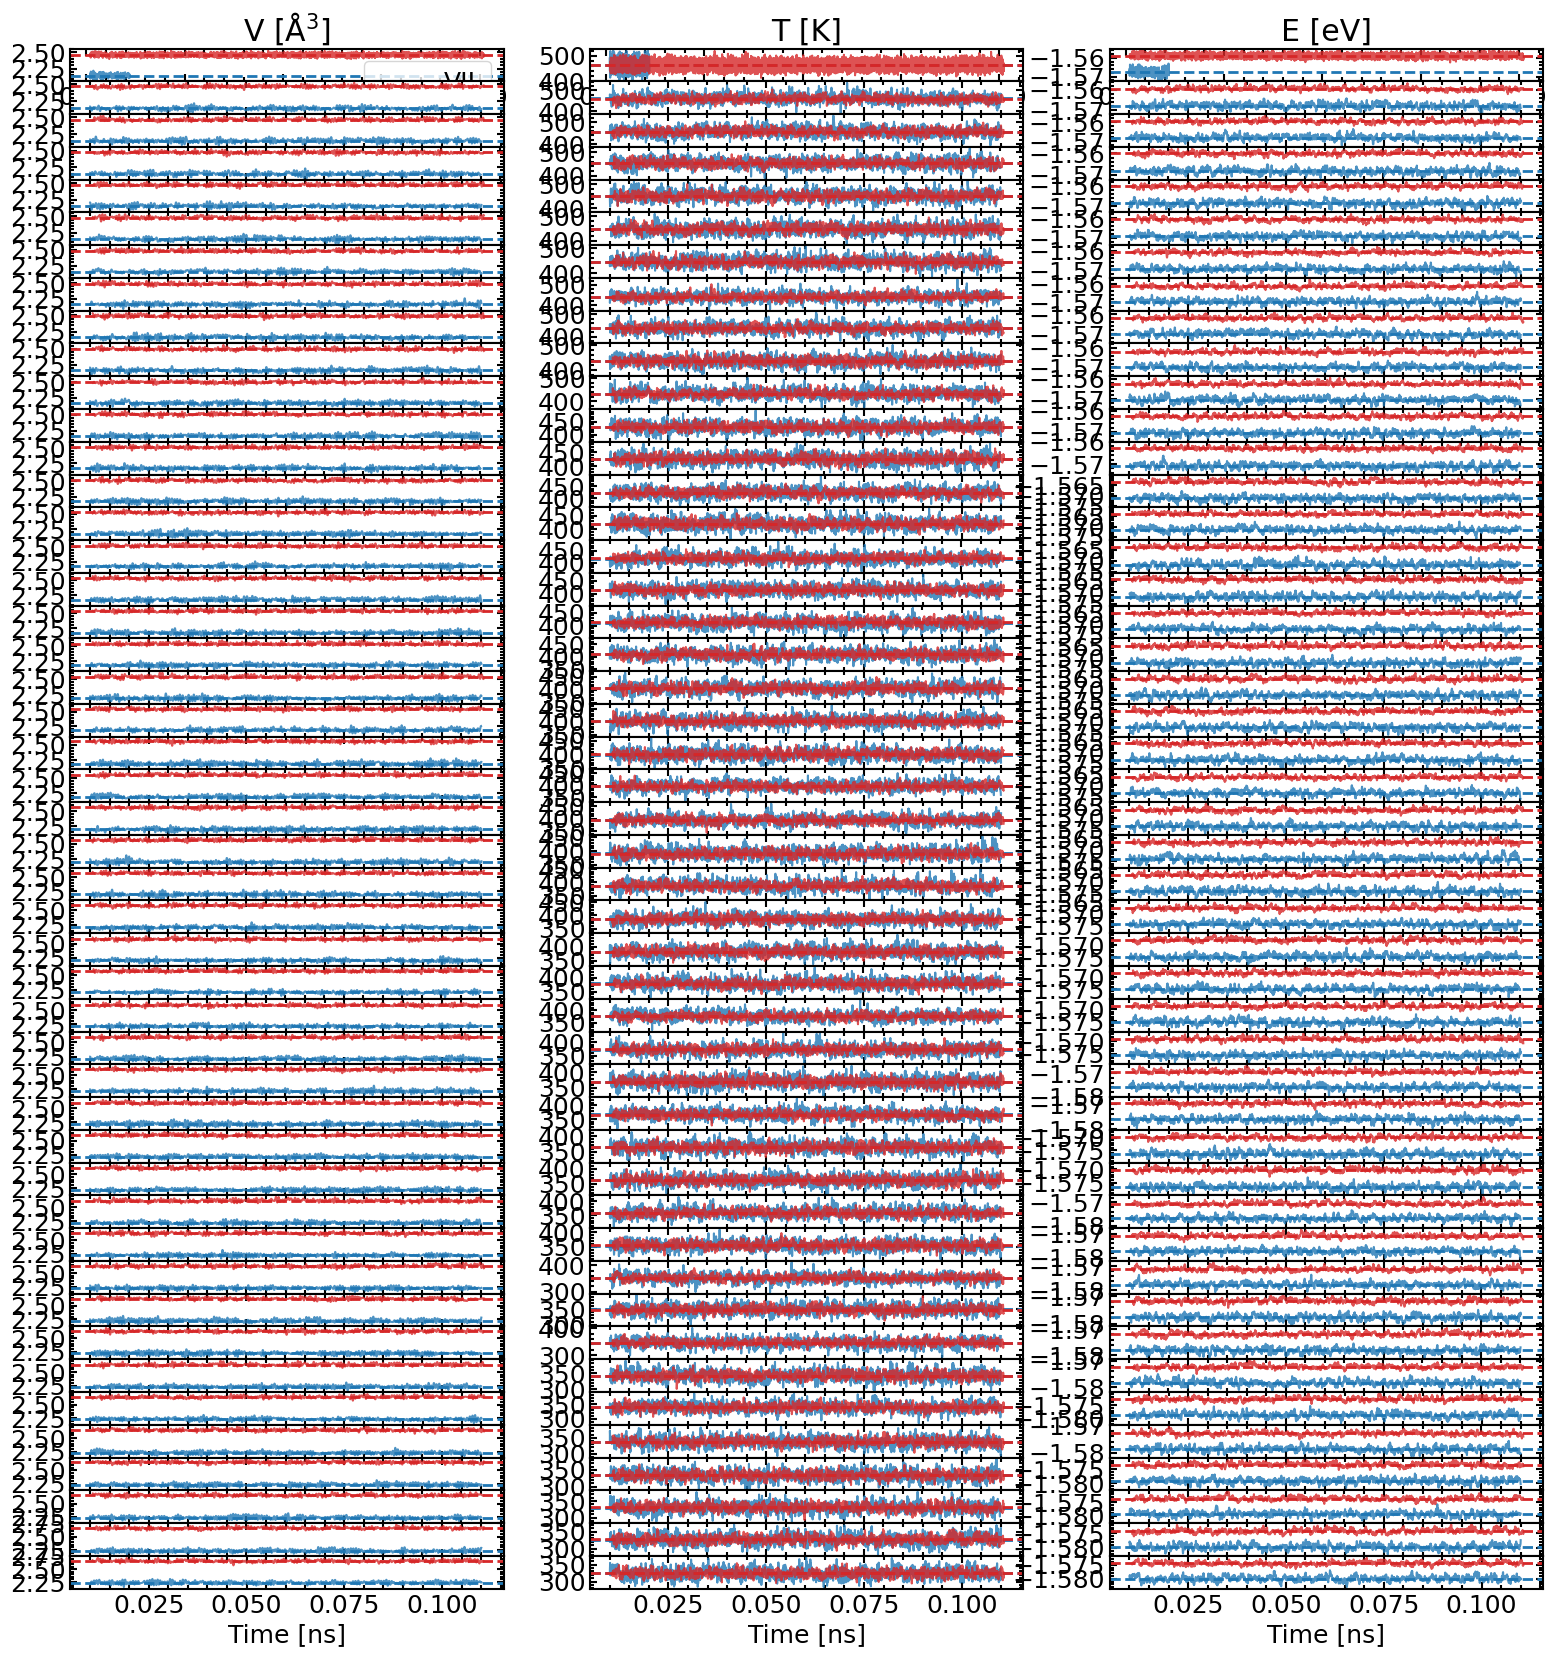

In [117]:
skip = 0
fig, ax = plt.subplots(figsize=(19,20), ncols=3, nrows=n_pnts)
fig.subplots_adjust(hspace=0)
alpha = 0.8
for i in range(n_pnts):
    path = f'/home/users/saadie5f/piaggi/phase_diagram/full/cc_int/vii-liq/vii_T_{T_lst[i]}_P_{P_lst[i]}'
    log = read_log(f'{path}')[-1]
        
    
    ax[i,0].plot(log.Step[skip:]*5e-7, log.Volume[skip:]/len(ph_1)/3, alpha=alpha, c='C0', label='VII')
    ax[i,0].axhline(log.Volume[skip:].mean()/len(ph_1)/3, ls='--', color='C0', lw=2)
    
    ax[i,1].plot(log.Step[skip:]*5e-7, log.Temp[skip:], alpha=alpha, c='C0')
    ax[i,1].axhline(log.Temp[skip:].mean(), ls='--', color='C0', lw=2)

    ax[i,2].plot(log.Step[skip:]*5e-7,log.TotEng[skip:]/len(ph_1)/3, alpha=alpha, c='C0')
    ax[i,2].axhline(log.TotEng[skip:].mean()/len(ph_1)/3, ls='--', color='C0', lw=2)
    
    path = f'/home/users/saadie5f/piaggi/phase_diagram/full/cc_int/vii-liq/liq_T_{T_lst[i]}_P_{P_lst[i]}'
    log = read_log(f'{path}')[-1]
        
    
    ax[i,0].plot(log.Step[skip:]*5e-7, log.Volume[skip:]/len(ph_2)/3, alpha=alpha, c='C3', label='Liq')
    ax[i,0].axhline(log.Volume[skip:].mean()/len(ph_2)/3, ls='--', color='C3', lw=2)
    
    ax[i,1].plot(log.Step[skip:]*5e-7, log.Temp[skip:], alpha=alpha, c='C3')
    ax[i,1].axhline(log.Temp[skip:].mean(), ls='--', color='C3', lw=2)

    ax[i,2].plot(log.Step[skip:]*5e-7,log.TotEng[skip:]/len(ph_2)/3, alpha=alpha, c='C3')
    ax[i,2].axhline(log.TotEng[skip:].mean()/len(ph_2)/3, ls='--', color='C3', lw=2)


ax[i,0].set_xlabel('Time [ns]')
ax[0,0].set_title('V [$\mathrm{\AA^{3}}$]')

ax[i,1].set_xlabel('Time [ns]')
ax[0,1].set_title('T [K]')

ax[i,2].set_xlabel('Time [ns]')
ax[0,2].set_title('E [eV]')
ax[0,0].legend()

In [50]:
vi_liq = np.loadtxt('/home/users/saadie5f/piaggi/phase_diagram/full/cc_int/data/vi_liq.dat')

In [119]:
T_lst_2 = T_lst
P_lst_2 = P_lst

In [123]:
T_lst = np.concatenate([T_lst_1,T_lst_2]) 
P_lst = np.concatenate([np.array(P_lst_1)*1e-4,np.array(P_lst_2)*1e-4])
args = np.argsort(T_lst)

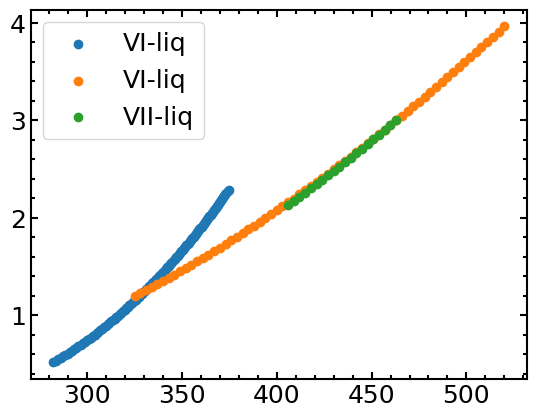

In [52]:
plt.scatter(vi_liq[0,:], vi_liq[1,:], label='VI-liq')
plt.scatter(vii_liq[0,:], vii_liq[1,:], label='VI-liq')
plt.scatter(T_lst, np.array(P_lst)*1e-4, label='VII-liq')
plt.legend()

In [125]:
np.savetxt('/home/users/saadie5f/piaggi/phase_diagram/full/cc_int/data/vii_liq.dat',
[T_lst[args], P_lst[args]])